# Capstone Project - League of Legends Champion Recommender

> Author: Ryan Yong

**Summary:**   
- Develop a Recommender System for recommending champions to users based on their account mastery points.
- Training data: Account & Champion Data

There are a total of 7 notebooks for this project:  
 1. `01a_data_scrape.ipynb`   
 2. `01b_wiki_scrape_fail.ipynb`   
 3. `02_champion_dataset_EDA.ipynb`
 4. `03_account_dataset_EDA.ipynb`
 5. `04_intial_recommender_system.ipynb`
 6. `05_final_hybrid_system.ipynb`
 7. `06_implementation.ipynb`

---
**This Notebook**
- performs EDA on the `champion_data.csv` file
- generates and outputs `engineered-champion_data.csv` file 

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [61]:
# Load the dataset
data = pd.read_csv('../data/champion_data.csv', index_col=False)

In [62]:
data.head()

,Champion,Class,Position,Resource,Range type,Adaptive type,Damage,Toughness,Control,Mobility,Utility,Style,Difficulty
0,Aatrox,Juggernaut,Top,Manaless,Melee,Physical,3,3,2,2,2,20,2
1,Ahri,Burst,Middle,Mana,Ranged,Magic,3,1,2,3,1,100,2
2,Akali,Assassin,Top Middle,Energy,Melee,Physical,3,1,1,3,1,65,2
3,Akshan,Marksman Assassin,Middle,Mana,Ranged,Physical,3,1,1,3,2,1,3
4,Alistar,Vanguard,Support,Mana,Melee,Magic,1,3,3,1,2,65,1


Noting from the data above, the categorical columns such as Class, Position, Resource, Range type and Adaptive type can be one-hot encoded.

The Code below plots of various numerical attributes champions possess, such as Damage, Toughness, Control, Mobility, Utility, Style & Difficulty. For reference, view the table below:

| Attribute   | Definition |
|-------------|------------|
| Damage      |A champion's ability to do Damage|
| Toughness   |A champion's ability to sustain Damage|
| Control     |A champion's ability to disrupt or disable enemies|
| Mobility    |A champion's ability to move around the map, blink or dash|
| Utility     |A champion's ability to grant beneficial effects to their allies or to provide vision on the map|
| Style       |A champion's tendency to exclusively use basic attacks (style = 0) or abilities (style = 100)|
| Difficulty  |The expected learning curve and required skill to pilot the champion|

These attributes will be plotted and compared for frequency to get a high-level view of the champions within the game.


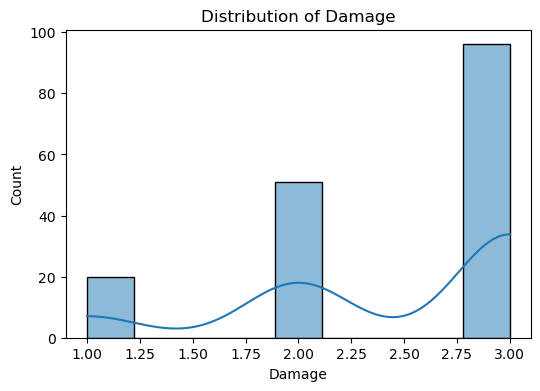

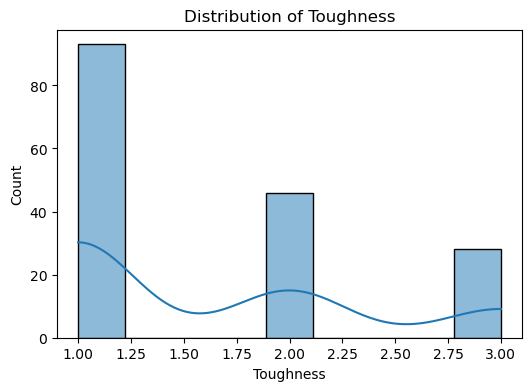

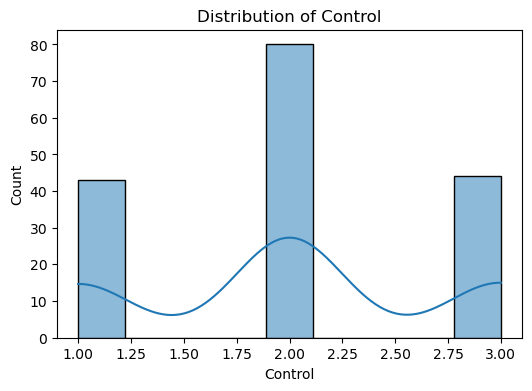

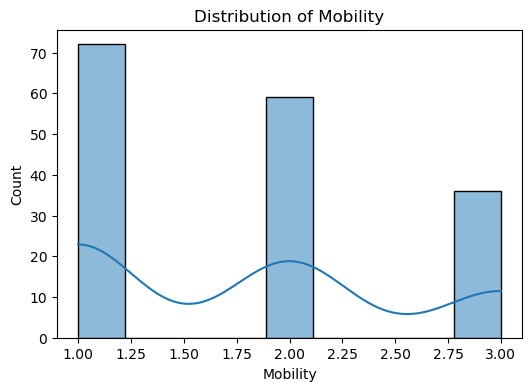

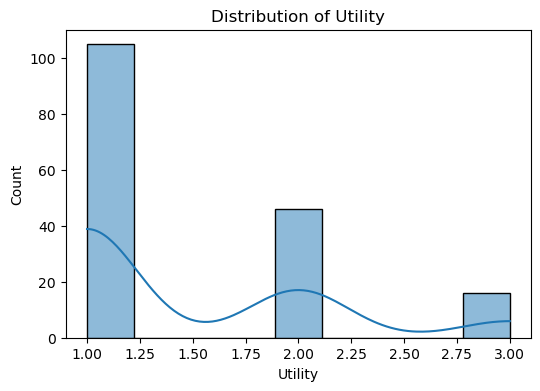

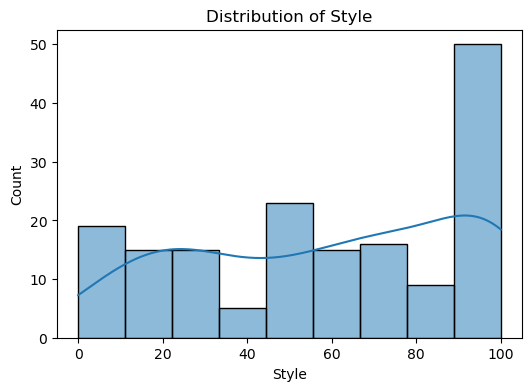

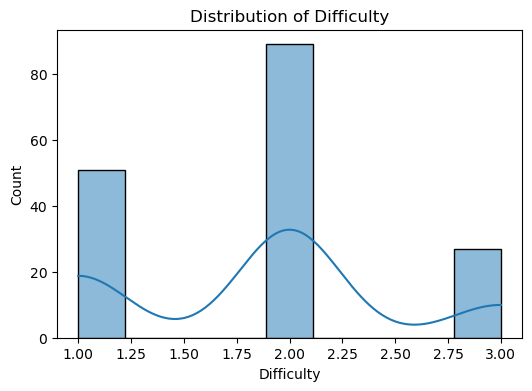

In [63]:
# Distribution of numeric attributes
numeric_columns = ['Damage', 'Toughness', 'Control', 'Mobility', 'Utility', 'Style', 'Difficulty']
for col in numeric_columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

Analysis of champion classes and their various metrics. Some Insights to take note of:

The inverse relationship between Damage and Toughness is an intentional balancing choice made by Riot Games. The concept behind it is a Give-And-Take system, where a champion who is high in Damage is expected to be low in Toughness. This prevents situations where by champions are high in both Damage & Toughness (Making them unfairly strong and over-used by players) and also situations where by champions are low in both Damage & Toughness (Making them unfairly weak and under-used by players).

Mobility is considered a dangerously strong attribute a champion should have, and therefore overly-mobile champions (See [Akali](https://leagueoflegends.fandom.com/wiki/Akali/LoL) & [Zed](https://leagueoflegends.fandom.com/wiki/Zed/LoL)) when piloted correctly by an experienced player will invoke frustrations from the player-base. Also, it is worth noting that when LoL was initially made back in 2010, most champions made are considered immobile champions if assessed in 2024. A deeper dive into the breakdown of the different mobility champions based on their year of creation would definitely bring more insight into the shape of the graph.

Style is generally well balanced across the buckets except for the value of 100. The reason for this abnormally high peak is due to the fact that there is a division of champions in the game that rely solely on spells. These champions are widely known as 'Spell-Casters', which can be sub-categorized later into Artillery, Burst, BattleMage or Enchanter. These classes are conceptually similar to the concept of a Magician or Wizard, the fantasy depiction of an entity able to wield magical powers.

Utility is a necessary but toxic attribute for a champion to have. In practice, Utility is a term to describe the concept of a champion's (Player A) ability to prevent another champion's (Player B) gameplay. A basic example of Utility would be ['Stun'](https://leagueoflegends.fandom.com/wiki/Types_of_Crowd_Control#Stun), where the Stunned target (Player B) will be unable to control its movement, declare attacks, cast abilities, activate items or use any summoner spells for the duration. Furthermore, it also interrupts most attack windups and all channelling and charged abilities. For this reason, champions with high Utility tend to have a reduction in most other attributes as well, as they can be very opressive within game. 

Lastly, Difficulty is well balanced across, with the highest (Difficulty = 3) being the lowest frequency and the middle (Difficulty = 2) being the highest frequency. It would make sense generally speaking as the main bulk of the player base would prefer medium-difficulty champions (Not too difficult to pilot but room for skill expression).


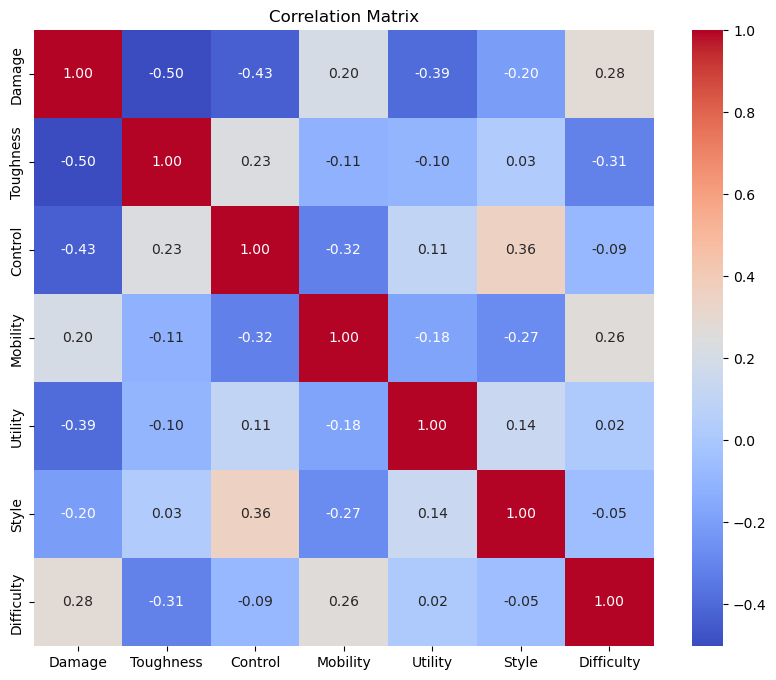

In [64]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(data[numeric_columns].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

It is worth noting from the heatmap that the corelations are due to the concept of balancing by the game developers. Classes with higher Damage are more corelated to have lesser Toughness and therefore higher Difficulty to play. This heatmap seems to reinforce most insights mentioned above, but generally speaking it is shown that higher damage champions tend to sacrifice other attributes such as Control/Toughness/Utility and only have mobility. Likewise, it can be shown that Toughness and Control are directly related as these champions tend to lack Damage and thus use their ability to Control as their form of influence in the game.

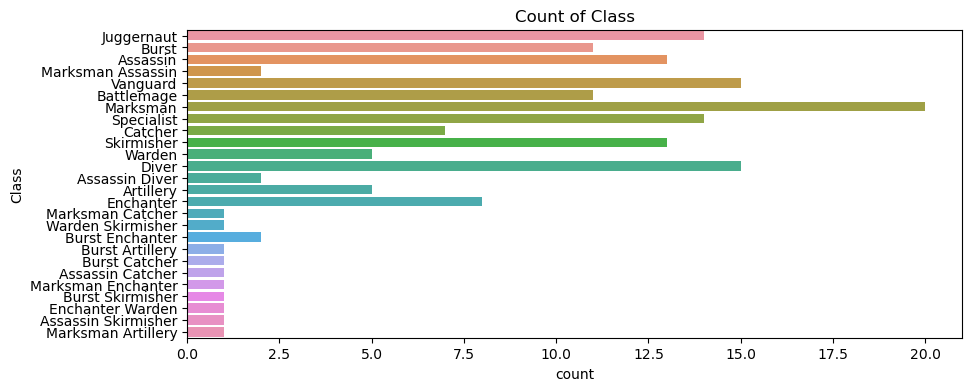

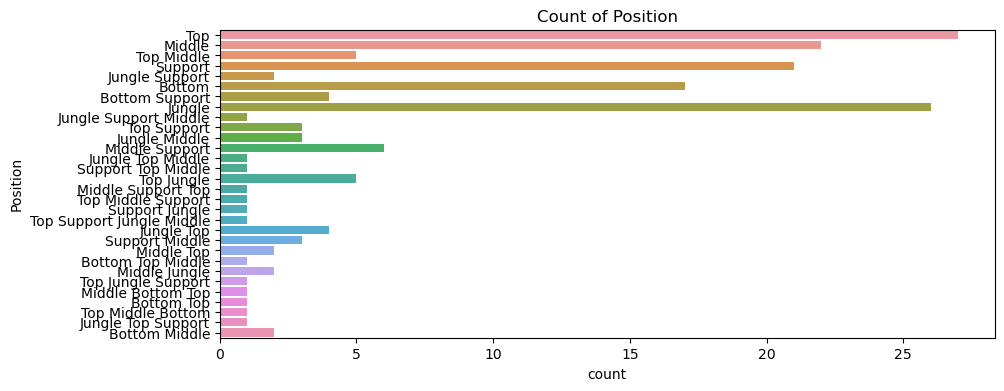

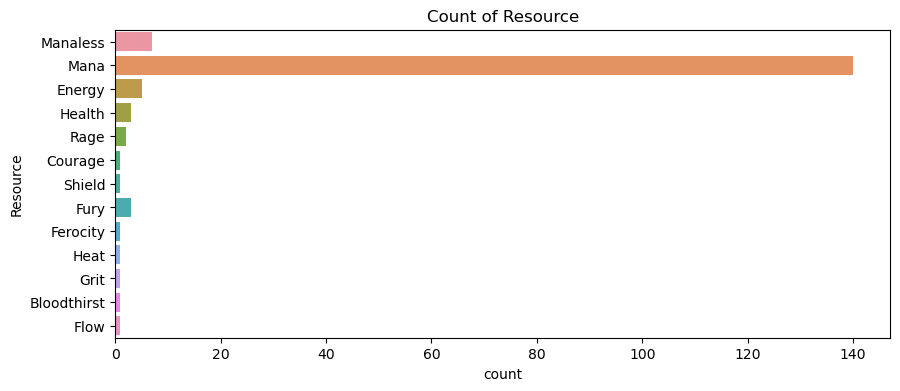

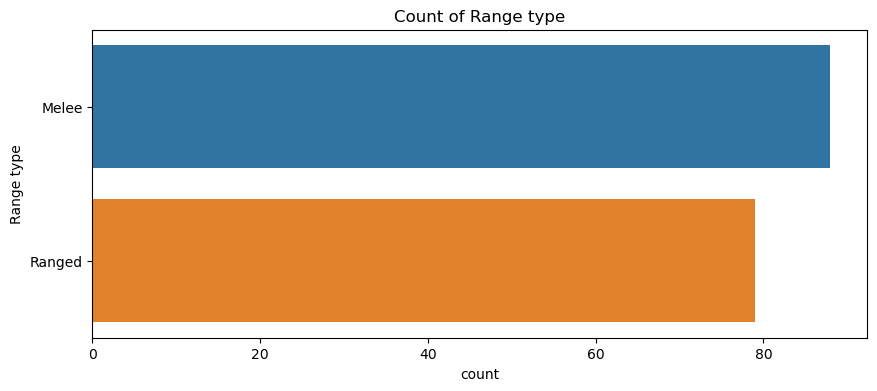

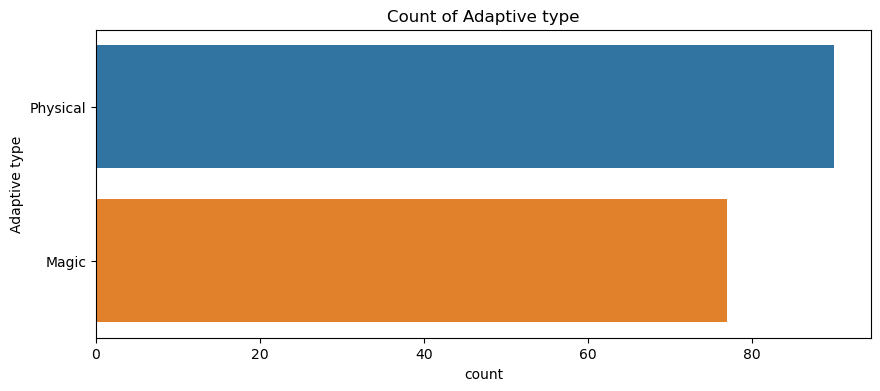

In [65]:
# Count plots for categorical data
categorical_columns = ['Class', 'Position', 'Resource', 'Range type', 'Adaptive type']
for col in categorical_columns:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=data, y=col)
    plt.title(f'Count of {col}')
    plt.show()

While the Adaptive type and Damage type are relatively similar, is worth noting the hybrid classes and positions of some champions which are flexible in that nature. this will be noted down when one-hot encoding the dataset. (I.e. Burst Skirmisher is a champion who would classify as both a Burst class as well as a Skirmisher Class.)

Furthermore, it can be seen that a majority of champions uses Mana as its secondary resource. A very small subset of non-Mana using champions use unique secondary resource (such as health/fury etc..). For the sake of the dataset, all non-Mana champions except Energy Champions will be re-classified under 'Manaless', as the non-Mana secondary resource does not limit the use of skills but invoke other aspects of the unique champion. 

Note: for the case of Energy Champions, it is a form of 'Mana' that operates differently and was developed to limit a group of champions with a resource that could not be upgradable in game. For that reason, I have made the executive decision to leave it separate from Mana and Manaless.

In [66]:
# Splitting the 'Class' and 'Position' columns where there are multiple entries
class_split = data['Class'].str.split(expand=True).stack().reset_index(level=1, drop=True)
position_split = data['Position'].str.split(expand=True).stack().reset_index(level=1, drop=True)

# Counting the occurrences of each unique class and position
class_count = class_split.value_counts()
position_count = position_split.value_counts()

class_count, position_count

# One-hot encoding the 'Class' and 'Position' columns where champions can be in multiple classes and positions

# First, let's create a DataFrame from the split data where each champion can appear multiple times with different classes and positions
expanded_classes = data[['Champion']].join(class_split.rename('Class'))
expanded_positions = data[['Champion']].join(position_split.rename('Position'))

# Now, perform one-hot encoding
class_one_hot = pd.get_dummies(expanded_classes, columns=['Class'], prefix='', prefix_sep='')
position_one_hot = pd.get_dummies(expanded_positions, columns=['Position'], prefix='', prefix_sep='')

# Summing up the one-hot encoded features for each champion
final_class_encoded = class_one_hot.groupby('Champion').sum()
final_position_encoded = position_one_hot.groupby('Champion').sum()

final_class_encoded.head(), final_position_encoded.head()


(          Artillery  Assassin  Battlemage  Burst  Catcher  Diver  Enchanter  \
 Champion                                                                      
 Aatrox            0         0           0      0        0      0          0   
 Ahri              0         0           0      1        0      0          0   
 Akali             0         1           0      0        0      0          0   
 Akshan            0         1           0      0        0      0          0   
 Alistar           0         0           0      0        0      0          0   
 
           Juggernaut  Marksman  Skirmisher  Specialist  Vanguard  Warden  
 Champion                                                                  
 Aatrox             1         0           0           0         0       0  
 Ahri               0         0           0           0         0       0  
 Akali              0         0           0           0         0       0  
 Akshan             0         1           0           0   

In [67]:
final_class_encoded.head(10)

,Artillery,Assassin,Battlemage,Burst,Catcher,Diver,Enchanter,Juggernaut,Marksman,Skirmisher,Specialist,Vanguard,Warden
Champion,,,,,,,,,,,,,
Aatrox,0,0,0,0,0,0,0,1,0,0,0,0,0
Ahri,0,0,0,1,0,0,0,0,0,0,0,0,0
Akali,0,1,0,0,0,0,0,0,0,0,0,0,0
Akshan,0,1,0,0,0,0,0,0,1,0,0,0,0
Alistar,0,0,0,0,0,0,0,0,0,0,0,1,0
Amumu,0,0,0,0,0,0,0,0,0,0,0,1,0
Anivia,0,0,1,0,0,0,0,0,0,0,0,0,0
Annie,0,0,0,1,0,0,0,0,0,0,0,0,0
Aphelios,0,0,0,0,0,0,0,0,1,0,0,0,0


Now that one-hot encoding is done, checking for indexes reveal data.index does not have the same index list as the newly encoded dataframes. Adjusting for that before merging is necessary to prevent mis-indexing.

In [68]:
print(final_position_encoded.index)
print(final_class_encoded.index)
print(data.index)

Index(['Aatrox', 'Ahri', 'Akali', 'Akshan', 'Alistar', 'Amumu', 'Anivia',
       'Annie', 'Aphelios', 'Ashe',
       ...
       'Yone', 'Yorick', 'Yuumi', 'Zac', 'Zed', 'Zeri', 'Ziggs', 'Zilean',
       'Zoe', 'Zyra'],
      dtype='object', name='Champion', length=167)
Index(['Aatrox', 'Ahri', 'Akali', 'Akshan', 'Alistar', 'Amumu', 'Anivia',
       'Annie', 'Aphelios', 'Ashe',
       ...
       'Yone', 'Yorick', 'Yuumi', 'Zac', 'Zed', 'Zeri', 'Ziggs', 'Zilean',
       'Zoe', 'Zyra'],
      dtype='object', name='Champion', length=167)
RangeIndex(start=0, stop=167, step=1)


In [69]:
# Set 'Champion' as the index for all relevant DataFrames
data.set_index('Champion', inplace=True)

# Merge the DataFrames
complete_merged = pd.concat([data, final_class_encoded,final_position_encoded], axis=1)

# If 'Class' and 'Position' columns are present, remove them
if 'Class' in complete_merged.columns:
    complete_merged.drop('Class', axis=1, inplace=True)
if 'Position' in complete_merged.columns:
    complete_merged.drop('Position', axis=1, inplace=True)

# Reset the index to turn 'Champion' back into a column
complete_merged.reset_index(inplace=True)

print(complete_merged.head())


  Champion  Resource Range type Adaptive type  Damage  Toughness  Control  \
0   Aatrox  Manaless      Melee      Physical       3          3        2   
1     Ahri      Mana     Ranged         Magic       3          1        2   
2    Akali    Energy      Melee      Physical       3          1        1   
3   Akshan      Mana     Ranged      Physical       3          1        1   
4  Alistar      Mana      Melee         Magic       1          3        3   

   Mobility  Utility  Style  Difficulty  Artillery  Assassin  Battlemage  \
0         2        2     20           2          0         0           0   
1         3        1    100           2          0         0           0   
2         3        1     65           2          0         1           0   
3         3        2      1           3          0         1           0   
4         1        2     65           1          0         0           0   

   Burst  Catcher  Diver  Enchanter  Juggernaut  Marksman  Skirmisher  \
0      

In [70]:
complete_merged.head()

,Champion,Resource,Range type,Adaptive type,Damage,Toughness,Control,Mobility,Utility,Style,Difficulty,Artillery,Assassin,Battlemage,Burst,Catcher,Diver,Enchanter,Juggernaut,Marksman,Skirmisher,Specialist,Vanguard,Warden,Bottom,Jungle,Middle,Support,Top
0,Aatrox,Manaless,Melee,Physical,3,3,2,2,2,20,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,Ahri,Mana,Ranged,Magic,3,1,2,3,1,100,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,Akali,Energy,Melee,Physical,3,1,1,3,1,65,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
3,Akshan,Mana,Ranged,Physical,3,1,1,3,2,1,3,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,Alistar,Mana,Melee,Magic,1,3,3,1,2,65,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [71]:
# Update the 'Resource' column: change all values not in ['Mana', 'Manaless', 'Energy'] to 'Manaless'
complete_merged['Resource'] = complete_merged['Resource'].apply(lambda x: x if x in ['Mana', 'Manaless', 'Energy'] else 'Manaless')


In [72]:
complete_merged.head()

,Champion,Resource,Range type,Adaptive type,Damage,Toughness,Control,Mobility,Utility,Style,Difficulty,Artillery,Assassin,Battlemage,Burst,Catcher,Diver,Enchanter,Juggernaut,Marksman,Skirmisher,Specialist,Vanguard,Warden,Bottom,Jungle,Middle,Support,Top
0,Aatrox,Manaless,Melee,Physical,3,3,2,2,2,20,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,Ahri,Mana,Ranged,Magic,3,1,2,3,1,100,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,Akali,Energy,Melee,Physical,3,1,1,3,1,65,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
3,Akshan,Mana,Ranged,Physical,3,1,1,3,2,1,3,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,Alistar,Mana,Melee,Magic,1,3,3,1,2,65,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [73]:
complete_merged.to_csv('../data/engineered_champion_data.csv')

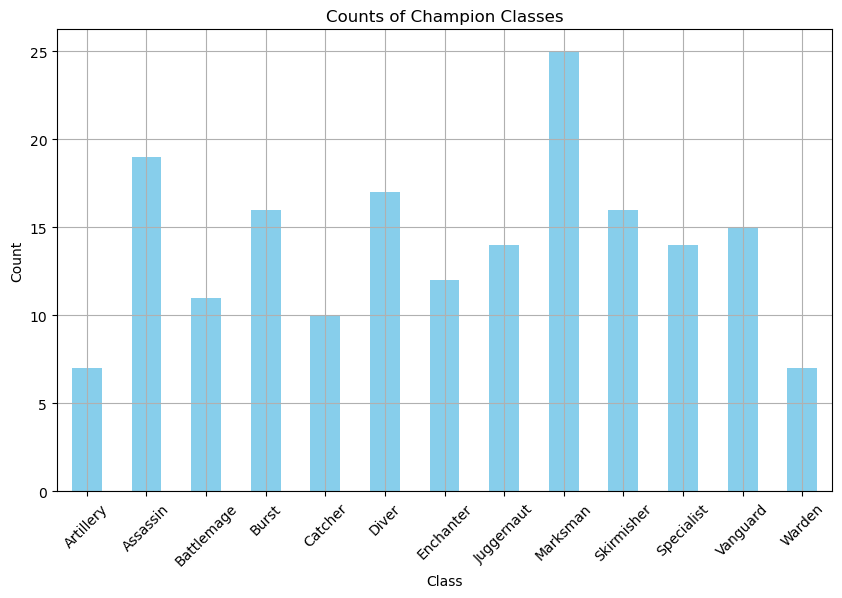

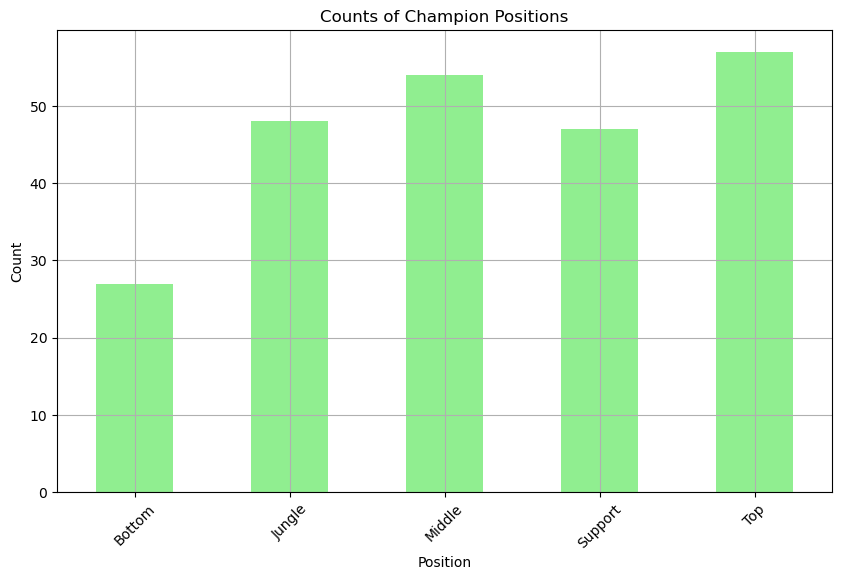

In [76]:
# Summing up the categories
class_sums = final_class_encoded.sum()
position_sums = final_position_encoded.sum()

# Plotting class category sums
plt.figure(figsize=(10, 6))
class_sums.plot(kind='bar', color='skyblue')
plt.title('Counts of Champion Classes')
plt.ylabel('Count')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plotting position category sums
plt.figure(figsize=(10, 6))
position_sums.plot(kind='bar', color='lightgreen')
plt.title('Counts of Champion Positions')
plt.ylabel('Count')
plt.xlabel('Position')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


It is worth noting that from a domain knowledge perspective, the 'Bottom' Position is ranked the lowest count as compared to the class 'Marksman' which is ranked the highest. This is actually because Marksman classes are typically played only in the Bottom position, and so while other roles are able to play champions from multiple classes, the number of champions listed 'Bottom' is much lower than the rest as they tend to come from a single Class of champions. This is important to highlight as I suspect the future systems might be affected by this imbalance in data.